# Composite height maps

This notebook can be used to composite multiple height maps with weighting factors for use in the 3D printable globe making workflow of Koelemeijer and Winterbourne 2021.

Height maps are images where the brightness of the image corresponds to the displacement you wish to make.  Input height maps can be generated in many ways - however, it is important to ensure you use a Cartesian map projection (also known as Flat Earth projection, _Plat Carée_ or simply "latitude and longitude").

__This notebook depends on the imageio, numpy and PIL libraries, which can be installed via Conda.__


In [1]:
###### Boilerplate

import imageio
import numpy as np
from PIL import Image


## Define the functions which are needed

In [2]:
def load_image( infilename ) : # image to numpy array
    """Open an image 
    as a numpy array using the imageio library
    
    Returns:
        Numpy array of pixel colours
    Arguments:
        infilename:  path to image file of standard type readable by imageio,
                     such as a jpeg, tiff, png etc
    """
    
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image(npdata, outfilename) : # output a clipped greyscale image from a numpy array
    """Write out an image from a 2D numpy array using the imageio library
    
    Arguments:
        npdata:  2D numpy array of single channel data
        outfilename: Path to output image in standard format controlled by file extension,
                     e.g. .jpeg, .tiff, .png etc
    """
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )
    
def scale(X, x_min, x_max):  #  rescale a numpy array between Xmin and xmax
    """Linearly rescale the values in a numpy array to a specified minimum and maximum
    
    Returns:
        rescaled numpy array
    Arguments:
        X: numpy array
        x_min, x_max:  intended range of output array
    """    
    nom = (X-X.min())*(x_max-x_min)
    denom = X.max() - X.min()
    if denom==0:
        denom=1
    return x_min + nom/denom    

def scale1d(X, x_min, x_max):   # rescale a numpy array by individual columns
    """Columnwise rescale the values in a numpy array to a specified minimum and maximum
    
    Returns:
        rescaled numpy array
    Arguments:
        X: numpy array
        x_min, x_max:  intended range of output array
    """
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

def im_to_scaled_array(imagefile, arrwidth, arrheight, arrmin, arrmax) : 
    """Read in an image file of 1, 3, or 4 channels (greyscale, RGB or RGBA), rescale to set 
    dimensions and return range scaled 2d numpy array of the mean of the RGB channels)
    
    Returns:
        Rescaled and resized 2D numpy array
    Arguments:
        imagefile: path to image file readable by imageio library (e.g. png, tiff or jpeg)
        arrwidth, arrheight: desired shape of the output array (in pixels)
        arrmin, arrmax: desired scale range of the output array
    """
    img = Image.open( imagefile )
    img.load()
    img=img.resize((arrwidth,arrheight), Image.ANTIALIAS)
    data=np.asarray( img, dtype="int32" )
    if len(data.shape) == 2:
        grey=data
    else:
        grey=data[:,:,0:3].mean(axis=2)
    return scale(grey,arrmin,arrmax)
    
    

# Compositing height maps

The example below composites 3 individual height maps using weighting, outputting a new image suitable for use in the 3D printable globe workflow of Koelemeijer and Winterbourne 2021.

Height maps are assumed to be greyscale images where white corresponds to the most positive (highest) topography, mid grey to neutral (unperturbed) and black to the most negative (deepest topography) in the output model.

In the example below we generate a height map suitable for creating a 3D printable globe of dynamic topography using data from Hoggard et al. 2016 

The 3 composited images are:
  - __dynamic_topo_height.png__: Dynamic topography model of Hoggard et al. 2016 dynamic topography model, (grid NGS-2015-07-01303-s07.grd from supplementary material in https://www.nature.com/articles/ngeo2709)
  - __world_topo.png__:  topography and bathymetry data from ETOPO1 (https://www.ngdc.noaa.gov/mgg/global/)
  - __coastline.png__: white land and black oceans, used to create a small step which allows visual identification of familiar coastlines in areas with extensive continental shelves, e.g. the UK and northern Australia
  
Input height maps can be easily created using a oneliner command in GMT 6 (https://www.generic-mapping-tools.org/).  (Note that this command implicitly assumes that the grid is symmetric - for more explict control it is advisable to create a specific colourbar using the makecpt command)

    gmt grdimage NGS-2015-07-01303-s07.grd -JX8i/4i -R-180/180/-90/90 -E -Cgray -png dynamic_topo_height

### Set up the parameters

Besides the desired output dimensions and location of the output image, you must provide a list of lists of the path to input height maps and the desired weighting factors (which need not sum to any specific number).  Any number of images can be composited.  Negative weights can be used to account for images with reverse polarity (i.e. images where black should be "up").

In [3]:
###  Setup

# Set the desired resolution of the output image.  The values below result in reasonable
# file sizes and runtimes but are sufficiently high resolution even for very high detail
# globes

width=2880
height=1440
outfile='height_maps/dynamic_topography_globe_composite_height_map.png' # path to the output file

# A list of lists with path to image and weighting factor, e.g.
# [['path1', weight1], ['path2', weight2], ...]
infiles=[['height_maps/coastline.png', 0.5],
         ['height_maps/world_topo.png', 2],
         ['height_maps/dynamic_topo_height.png', 10]
        ]

### Run the code and visualise the output

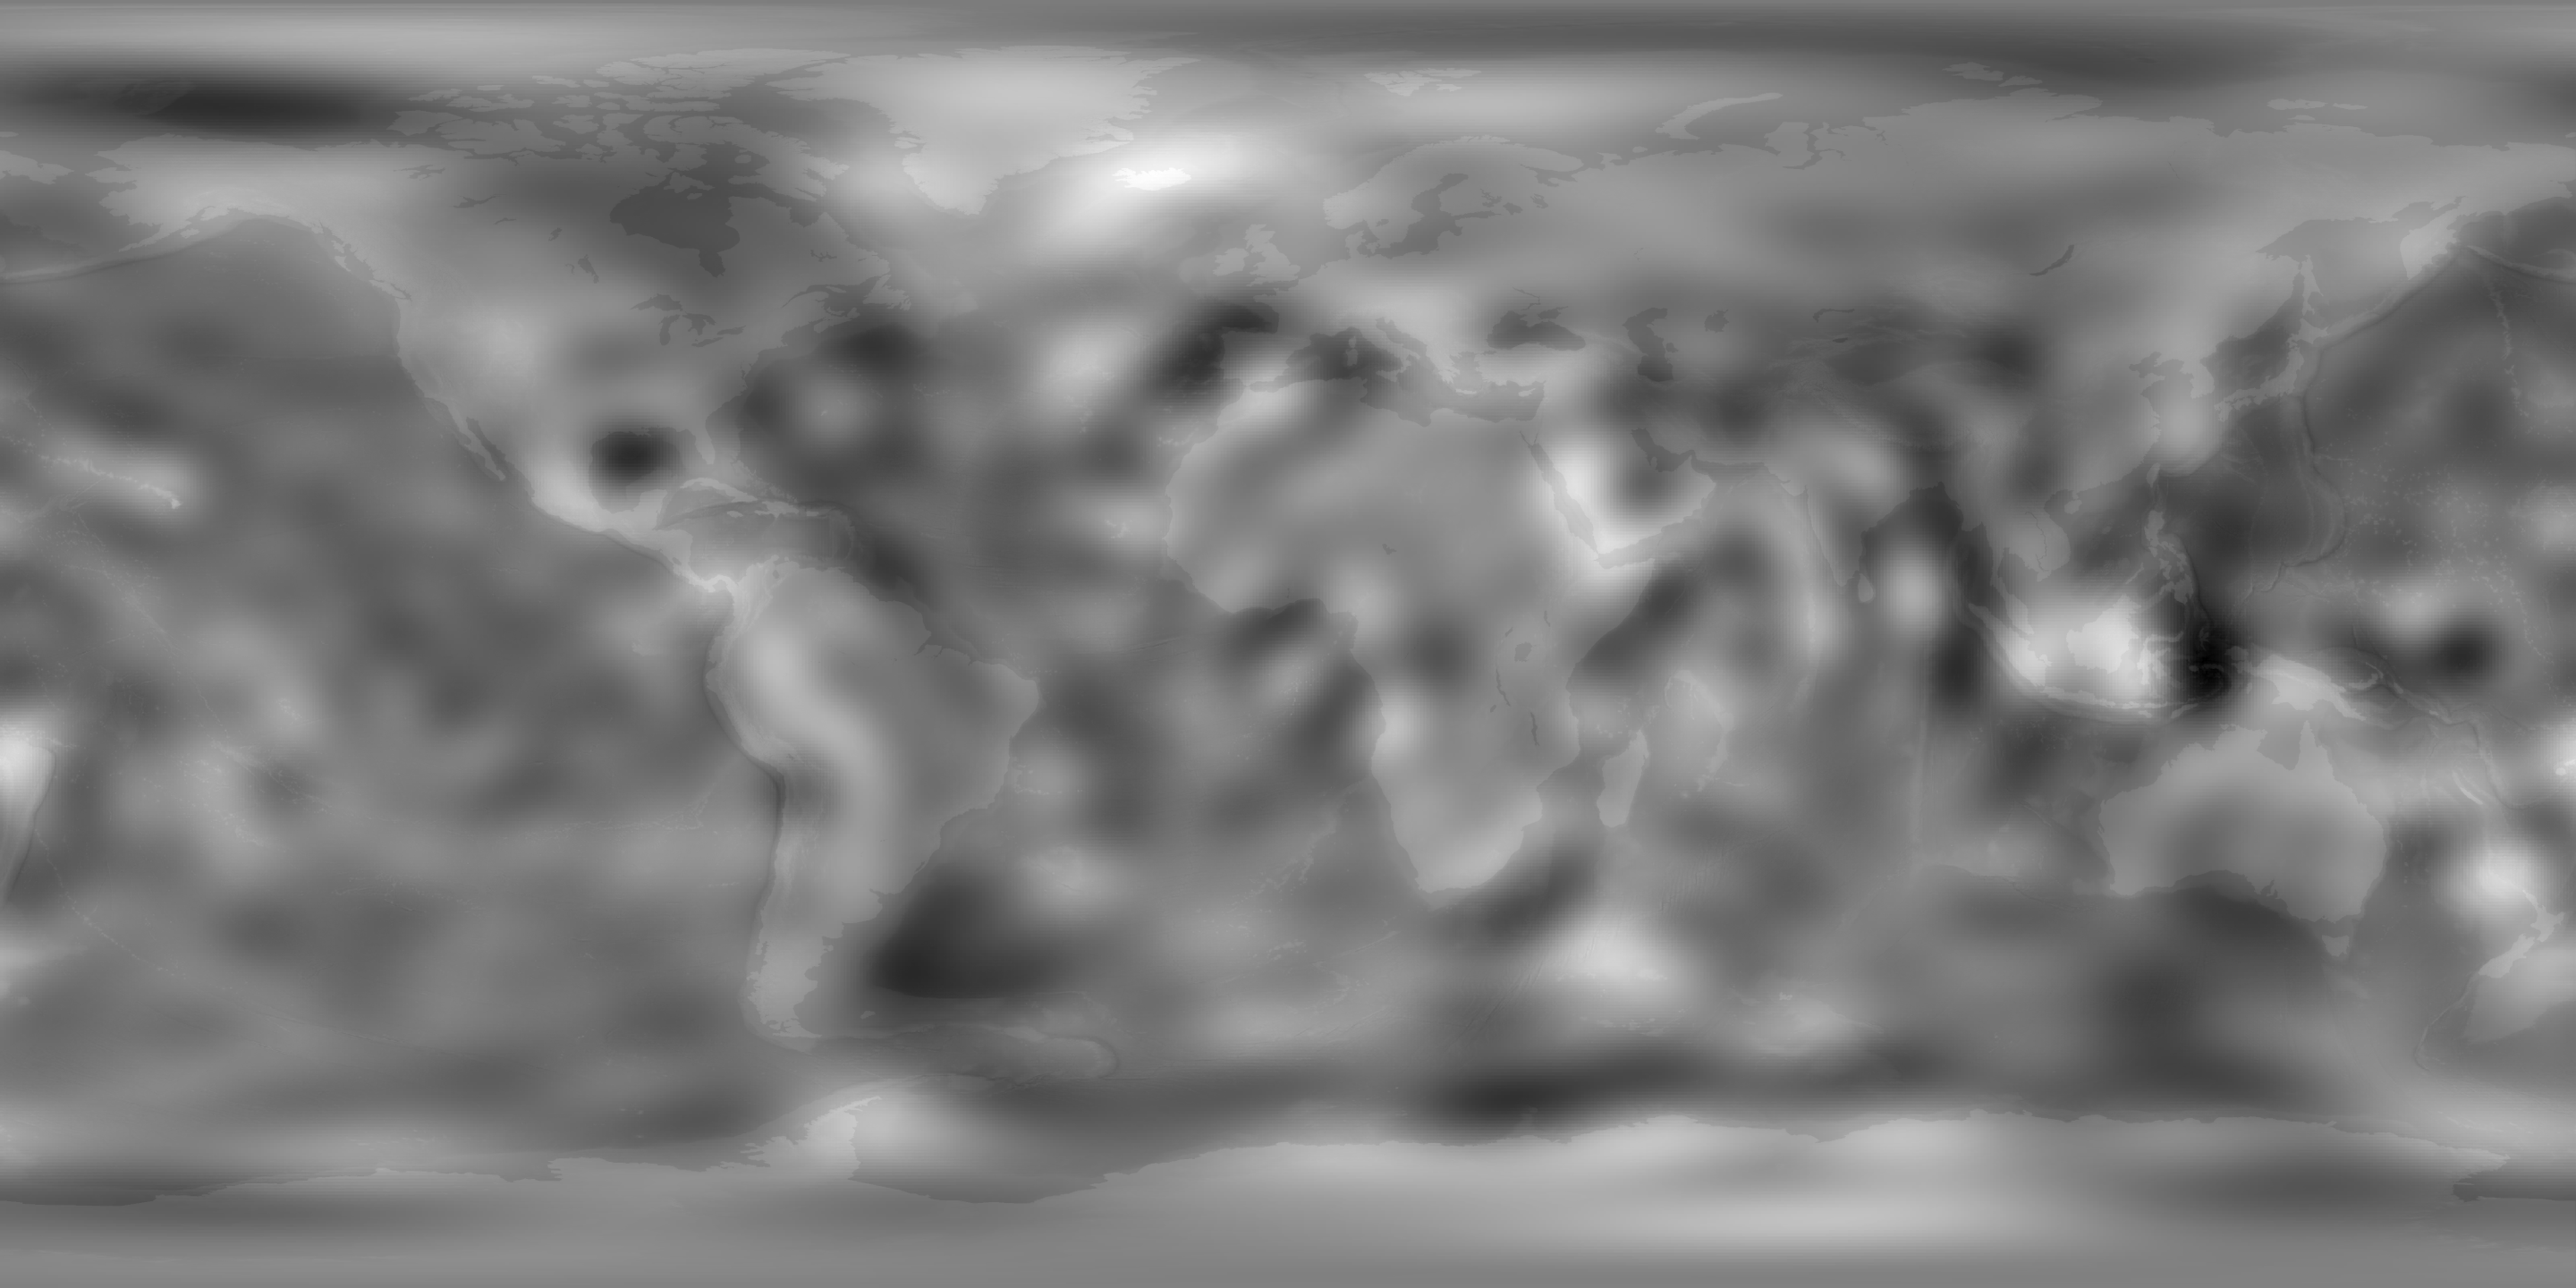

In [4]:
# Initialise an array of the correct size with zeroes
outarray=np.zeros((height,width))

# Iterate over the list of inputs and weights
for i in range(len(infiles)):
    # open, read and resample the image into an array of the right scale, apply the weighting factor
    # syntax: im_to_scaled_array(infile, width, height, outmin, outmax)
    scaled=im_to_scaled_array(infiles[i][0], width, height, 0, infiles[i][1])
    
    # add array to the output
    outarray=np.add(outarray, scaled)

# Write out the image to an 8-bit grayscale outputfile using the full dynamic range available
save_image(scale(outarray,0,255),outfile)

# Read the newly created file and display it inline for QC
outimg = Image.open(outfile)
display(outimg)